In [299]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision.models import vgg19_bn
import numpy as np

import os
data_dir = os.path.expanduser("~/nta/results")

import matplotlib.pyplot as plt
%matplotlib inline

# fix a random seed
torch.manual_seed(32)

# set device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## 1. Run regular MLP on MNIST

#### Load dataset

In [317]:
dataset = 'FashionMNIST'

In [318]:
# check mean and std
tempset = getattr(datasets, dataset)(root=data_dir, train=True,
                                     transform=transforms.ToTensor(), download=True)
datastats_mean = tempset.train_data.float().mean().item()/255
datastats_std = tempset.train_data.float().std().item()/255
print(datastats_mean, datastats_std)
del tempset

0.2860164866727941 0.35302426207299326


In [319]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.1307,), (0.3081,)), #MNIST
        transforms.Normalize((datastats_mean,), (datastats_std,)),
    ]
)

In [320]:
train_set = getattr(datasets, dataset)(root=data_dir, train=True, transform=transform, 
                                       download=True)
test_set = getattr(datasets, dataset)(root=data_dir, train=False, transform=transform, 
                                      download=True)

In [321]:
train_set.train_data[0].shape

torch.Size([28, 28])

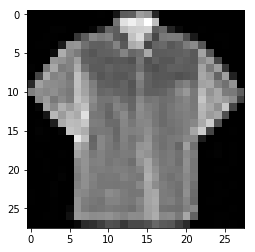

In [322]:
img = train_set.train_data[np.random.randint(60000)].numpy()
plt.imshow(img, cmap='gray')

In [323]:
batch_size_train = 128
batch_size_test = 128
train_loader = DataLoader(dataset=train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size_test, shuffle=False)

#### Create model

In [300]:
class MLP(nn.Module):
    
    def __init__(self, input_size=784, num_classes=10, init_weights=True,
                 hidden_sizes = [1000, 1000, 1000], device=device):
        
        super(MLP, self).__init__()
        self.device = device
        self.input_size = input_size
        
        self.classifier = nn.Sequential(
            nn.Linear(self.input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], num_classes)
        ).to(self.device)
        
        if init_weights:
            self._initialize_weights()
        
    def forward(self, x):
        return self.classifier(x.view(-1, self.input_size).to(self.device))
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    

In [10]:
model = MLP(device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()

In [301]:
def run_epoch(model, loss_func, loader, optimizer=None, train=True):

    epoch_loss = 0
    num_samples = 0
    correct = 0
    for data in loader:
        # get inputs and label
        inputs, targets = data
        targets = targets.to(device)
        
        # zero gradients
        if train: optimizer.zero_grad()
                
        # forward + backward + optimize
        outputs = model(inputs)
        correct += (targets==torch.max(outputs, dim=1)[1]).sum().item()
        loss = loss_func(outputs, targets)
        if train:
            loss.backward()
            optimizer.step()

        # keep track of loss
        epoch_loss += loss.item()
        num_samples += inputs.shape[0]
        
    return (epoch_loss / num_samples) * 1000, correct/num_samples


In [302]:
def run_experiment(epochs=20):
    max_train_acc = 0
    max_val_acc = 0
    for epoch in range(epochs):    
        model.train()
        train_loss, train_acc = run_epoch(model, loss_func, train_loader, optimizer, train=True)
        max_train_acc = max(train_acc, max_train_acc)
        model.eval()
        val_loss, val_acc     = run_epoch(model, loss_func, test_loader, train=False)
        max_val_acc = max(val_acc, max_val_acc)        
        print('Epoch: %d Train loss: %.4f Train Acc: %.4f Val loss: %.4f Val Acc: %.4f' % 
              (epoch + 1, train_loss, train_acc, val_loss, val_acc))
    print('\nFinal - Best Train Acc: %.4f Best Val acc: %.4f' % (max_train_acc, max_val_acc))

In [13]:
%%time
run_experiment(20)

Epoch: 1 Train loss: 5.1337 Train Acc: 0.7699 Val loss: 3.8193 Val Acc: 0.8230
Epoch: 2 Train loss: 3.2550 Train Acc: 0.8486 Val loss: 3.2947 Val Acc: 0.8466
Epoch: 3 Train loss: 2.8686 Train Acc: 0.8652 Val loss: 3.1101 Val Acc: 0.8545
Epoch: 4 Train loss: 2.6161 Train Acc: 0.8771 Val loss: 2.8331 Val Acc: 0.8686
Epoch: 5 Train loss: 2.4346 Train Acc: 0.8852 Val loss: 2.7914 Val Acc: 0.8739
Epoch: 6 Train loss: 2.2850 Train Acc: 0.8910 Val loss: 2.7238 Val Acc: 0.8762
Epoch: 7 Train loss: 2.1571 Train Acc: 0.8985 Val loss: 2.5857 Val Acc: 0.8825
Epoch: 8 Train loss: 2.0290 Train Acc: 0.9032 Val loss: 2.6326 Val Acc: 0.8796
Epoch: 9 Train loss: 1.9257 Train Acc: 0.9095 Val loss: 2.5624 Val Acc: 0.8803
Epoch: 10 Train loss: 1.8362 Train Acc: 0.9138 Val loss: 2.4978 Val Acc: 0.8843
Epoch: 11 Train loss: 1.7460 Train Acc: 0.9177 Val loss: 2.5304 Val Acc: 0.8833
Epoch: 12 Train loss: 1.6392 Train Acc: 0.9229 Val loss: 2.5593 Val Acc: 0.8878
Epoch: 13 Train loss: 1.5546 Train Acc: 0.9270 Va

## 2. Create an improved model of it

In [303]:
# added: relu, batchnorm, dropout at second to last layer, weight decay
def new_init(self, input_size=784, num_classes=10, init_weights=True,
             hidden_sizes = [1000, 1000, 1000], device=device):

    super(MLP, self).__init__()
    self.device = device
    self.input_size = input_size

    self.classifier = nn.Sequential(
        nn.Linear(self.input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_sizes[0]),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_sizes[1]),
        nn.Linear(hidden_sizes[1], hidden_sizes[2]),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_sizes[2]),
        nn.Linear(hidden_sizes[2], num_classes)
    ).to(self.device)

    if init_weights:
        self._initialize_weights()
        
MLP.__init__ = new_init

In [15]:
# switch to SGD with weight decay
model = MLP(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=2e-4, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [16]:
%%time
run_experiment(20)

Epoch: 1 Train loss: 3.5526 Train Acc: 0.8385 Val loss: 3.0888 Val Acc: 0.8567
Epoch: 2 Train loss: 2.6959 Train Acc: 0.8710 Val loss: 2.9206 Val Acc: 0.8620
Epoch: 3 Train loss: 2.4448 Train Acc: 0.8837 Val loss: 2.7977 Val Acc: 0.8674
Epoch: 4 Train loss: 2.2292 Train Acc: 0.8946 Val loss: 2.8411 Val Acc: 0.8692
Epoch: 5 Train loss: 2.1174 Train Acc: 0.8983 Val loss: 2.6486 Val Acc: 0.8808
Epoch: 6 Train loss: 2.0019 Train Acc: 0.9031 Val loss: 2.6650 Val Acc: 0.8796
Epoch: 7 Train loss: 1.8990 Train Acc: 0.9078 Val loss: 2.5938 Val Acc: 0.8804
Epoch: 8 Train loss: 1.8067 Train Acc: 0.9133 Val loss: 2.7324 Val Acc: 0.8779
Epoch: 9 Train loss: 1.7261 Train Acc: 0.9174 Val loss: 2.6742 Val Acc: 0.8830
Epoch: 10 Train loss: 1.6300 Train Acc: 0.9219 Val loss: 2.5833 Val Acc: 0.8843
Epoch: 11 Train loss: 1.5823 Train Acc: 0.9237 Val loss: 2.7901 Val Acc: 0.8837
Epoch: 12 Train loss: 1.5265 Train Acc: 0.9257 Val loss: 2.7427 Val Acc: 0.8864
Epoch: 13 Train loss: 1.4568 Train Acc: 0.9292 Va

* Best results on MNIST after 80 epochs are 0.9885 and final 0.9876, better than reported in the paper

## 3. Implement fixed sparsity

In [304]:
# added: relu, batchnorm, dropout at second to last layer, weight decay
def new_init(self, input_size=784, num_classes=10, init_weights=True,
             hidden_sizes = [1000, 1000, 1000], device=device,
             epsilon=20, bias=False):

    super(MLP, self).__init__()
    self.device = device
    self.input_size = input_size
           
    self.classifier = nn.Sequential(
        nn.Linear(self.input_size, hidden_sizes[0], bias=bias),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_sizes[0]),
        nn.Linear(hidden_sizes[0], hidden_sizes[1], bias=bias),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_sizes[1]),
        nn.Linear(hidden_sizes[1], hidden_sizes[2], bias=bias),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_sizes[2]),
        nn.Linear(hidden_sizes[2], num_classes, bias=bias)
    ).to(self.device)

    # calculate sparsity masks
    self.masks = []
    linear_layers = [m for m in self.modules() if isinstance(m, nn.Linear)]
    for i, layer in enumerate(linear_layers,1):
        shape = layer.weight.shape
        sparsity = (shape[0]+shape[1])/(shape[0]*shape[1])
        # at last layer, can't apply epsilon =20 - see calculations
        if i != len(linear_layers): sparsity *= epsilon
        mask = torch.rand(shape) < sparsity
        self.masks.append(mask.float().to(self.device))
    
    if init_weights:
        self._initialize_weights()

def new_initialize_weights(self):
              
    masks = iter(self.masks)
    for m in self.modules():
        if isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
        elif isinstance(m, nn.Linear):           
            with torch.no_grad():
                tensor = (torch.randn(m.weight.shape) * 1e-2).to(self.device)
                tensor = tensor * next(masks)
            m.weight = torch.nn.Parameter(tensor)            

MLP.__init__ = new_init
MLP._initialize_weights = new_initialize_weights

In [18]:
# switch to SGD with weight decay
model = MLP(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=2e-4, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [305]:
def run_epoch(model, loss_func, loader, optimizer=None, train=True):

    epoch_loss = 0
    num_samples = 0
    correct = 0
    for data in loader:
        # get inputs and label
        inputs, targets = data
        targets = targets.to(device)
        
        # zero gradients
        if train: optimizer.zero_grad()
                
        # forward + backward + optimize
        outputs = model(inputs)
        correct += (targets==torch.max(outputs, dim=1)[1]).sum().item()
        loss = loss_func(outputs, targets)
        if train:
            loss.backward()
            # zero the gradients in the dead connections
            masks = iter(model.masks)
            for m in model.modules():
                if isinstance(m, nn.Linear):
                    m.weight.grad *= next(masks)
            # optimize
            optimizer.step()

        # keep track of loss
        epoch_loss += loss.item()
        num_samples += inputs.shape[0]
        
    return (epoch_loss / num_samples) * 1000, correct/num_samples



In [21]:
%%time
run_experiment(20)

Epoch: 1 Train loss: 3.7621 Train Acc: 0.8328 Val loss: 2.9747 Val Acc: 0.8651
Epoch: 2 Train loss: 2.7088 Train Acc: 0.8745 Val loss: 2.7837 Val Acc: 0.8693
Epoch: 3 Train loss: 2.4467 Train Acc: 0.8849 Val loss: 2.6173 Val Acc: 0.8760
Epoch: 4 Train loss: 2.2475 Train Acc: 0.8932 Val loss: 2.5732 Val Acc: 0.8807
Epoch: 5 Train loss: 2.0787 Train Acc: 0.9016 Val loss: 2.6679 Val Acc: 0.8780
Epoch: 6 Train loss: 1.9581 Train Acc: 0.9065 Val loss: 2.6185 Val Acc: 0.8844
Epoch: 7 Train loss: 1.8417 Train Acc: 0.9122 Val loss: 2.5329 Val Acc: 0.8848
Epoch: 8 Train loss: 1.7650 Train Acc: 0.9163 Val loss: 2.4876 Val Acc: 0.8867
Epoch: 9 Train loss: 1.6626 Train Acc: 0.9214 Val loss: 2.5397 Val Acc: 0.8839
Epoch: 10 Train loss: 1.6090 Train Acc: 0.9230 Val loss: 2.4845 Val Acc: 0.8865
Epoch: 11 Train loss: 1.5298 Train Acc: 0.9266 Val loss: 2.5219 Val Acc: 0.8896
Epoch: 12 Train loss: 1.4554 Train Acc: 0.9296 Val loss: 2.5165 Val Acc: 0.8846
Epoch: 13 Train loss: 1.3989 Train Acc: 0.9333 Va

In [32]:
# Test: sparsity holds at the end of training
for m in model.modules():
    if isinstance(m, nn.Linear):
        zeros = torch.sum((m.weight == 0).int()).item()
        size = np.prod(m.weight.shape)
        print(1- zeros/size)


0.045239795918367354
0.03987799999999997
0.039995
0.10340000000000005


Doesn't seem to loose a lot of performance

## 3. Implement SET sparsity

In [345]:
# calculate the magnitude treshold
def non_zero(tensor):
    """ Support function. Accepts a tensor, returns a tensor with only non-zero values """
    return tensor.view(-1)[tensor.view(-1).nonzero()].view(-1)        
        
def sep_update(self, A, M, zeta=0.3):
        """ Calculate new weights based on SEP approach """

        shape = A.shape
        n_total = np.prod(shape)
        n_zeros = torch.sum(A == 0).item()
        n_values = n_total - n_zeros
        sparsity = n_zeros / n_total

        A_abs = torch.abs(A)
        threshold, _ = torch.kthvalue(non_zero(A_abs), int(zeta*(n_values)))
        N = A_abs > threshold.item()
        A_prime = A * N.float()

        # extract mean and std of current weights
        # if batch norm, can also get from the batch norm layer the running mean and std?
        A_nonzero = non_zero(A)
        prev_mean = torch.mean(A_nonzero)
        prev_std = torch.std(A_nonzero)

        # initialize matrix of random values 
        R = torch.randn(shape).to(self.device) * prev_std + prev_mean 
        # zero out values where there were previous weights
        R_prime = R * (M == 0).float()
        # decide which matrices to keep
        p_update = zeta / (1-sparsity)
        P = torch.rand(shape).to(self.device) < p_update
        # only keep weights selected
        R_double_prime = R_prime * P.float()

        # get final matrix 
        return (A_prime + R_double_prime).to(self.device)    
    
def reinitialize_weights(self):        
    """ Reinitialize weights """

    zeta = 0.3
    masks = enumerate(self.masks, 0)
    for m in self.modules():
        if isinstance(m, nn.Linear):           
            mask_idx, mask = next(masks)
            new_weights = self.sep_update(m.weight, mask, zeta)
            self.masks[mask_idx] = (new_weights > 0).float().to(self.device)
        
MLP.sep_update = sep_update
MLP.reinitialize_weights = reinitialize_weights

In [346]:
# switch to SGD with weight decay
model = MLP(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=2e-4, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [347]:
def run_epoch(model, loss_func, loader, optimizer=None, train=True):

    epoch_loss = 0
    num_samples = 0
    correct = 0
    for data in loader:
        # get inputs and label
        inputs, targets = data
        targets = targets.to(device)
        
        # zero gradients
        if train: optimizer.zero_grad()
                
        # forward + backward + optimize
        outputs = model(inputs)
        correct += (targets==torch.max(outputs, dim=1)[1]).sum().item()
        loss = loss_func(outputs, targets)
        if train:
            loss.backward()
            # zero the gradients in the dead connections
            masks = iter(model.masks)
            for m in model.modules():
                if isinstance(m, nn.Linear):
                    m.weight.grad *= next(masks)
            # optimize
            optimizer.step()
            
        # keep track of loss
        epoch_loss += loss.item()
        num_samples += inputs.shape[0]
        
    # at the end of epoch, reinitialize weights
    model.reinitialize_weights()
        
    return (epoch_loss / num_samples) * 1000, correct/num_samples



In [348]:
%%time
run_experiment(20)

Epoch: 1 Train loss: 3.7417 Train Acc: 0.8320 Val loss: 2.9447 Val Acc: 0.8664
Epoch: 2 Train loss: 3.2295 Train Acc: 0.8503 Val loss: 3.0452 Val Acc: 0.8537
Epoch: 3 Train loss: 2.7279 Train Acc: 0.8720 Val loss: 2.7827 Val Acc: 0.8726
Epoch: 4 Train loss: 2.4835 Train Acc: 0.8826 Val loss: 2.8961 Val Acc: 0.8661
Epoch: 5 Train loss: 2.3017 Train Acc: 0.8902 Val loss: 2.8072 Val Acc: 0.8730
Epoch: 6 Train loss: 2.1768 Train Acc: 0.8965 Val loss: 3.0672 Val Acc: 0.8649
Epoch: 7 Train loss: 2.0383 Train Acc: 0.9038 Val loss: 2.8482 Val Acc: 0.8743
Epoch: 8 Train loss: 1.9319 Train Acc: 0.9070 Val loss: 2.7546 Val Acc: 0.8788
Epoch: 9 Train loss: 1.8487 Train Acc: 0.9115 Val loss: 2.6805 Val Acc: 0.8817
Epoch: 10 Train loss: 1.7777 Train Acc: 0.9155 Val loss: 2.6514 Val Acc: 0.8876
Epoch: 11 Train loss: 1.7033 Train Acc: 0.9183 Val loss: 2.8771 Val Acc: 0.8812
Epoch: 12 Train loss: 1.6482 Train Acc: 0.9204 Val loss: 2.6498 Val Acc: 0.8890
Epoch: 13 Train loss: 1.5534 Train Acc: 0.9249 Va

##### 3.2 Convert to pytorch

In [294]:
import torch

In [295]:
sparsity = 0.05
shape = (100, 100)
# initial weights matrix
A = torch.randn(shape) * 1e-2
# sparse mask
M = torch.rand(shape) < sparsity
# apply sparse mask
A = M.float() * A

In [296]:
# calculate the magnitude treshold
def non_zero(tensor):
    return tensor.view(-1)[tensor.view(-1).nonzero()].view(-1)

n_total = np.prod(shape)
n_zeros = torch.sum(A == 0).item()
n_values = n_total - n_zeros
zeta = 0.3
A_abs = torch.abs(A)

# threshold = torch.kthvalue(A.view(-1), n_values*zeta + n_zeros)
threshold, _ = torch.kthvalue(non_zero(A_abs), int(zeta*(n_values)))
N = A_abs > threshold.item()
A_prime = A * N.float()

# assure that the mean of absolute values has increased
prev_mean = torch.mean(torch.abs(non_zero(A)))
post_mean = torch.mean(torch.abs(non_zero(A_prime)))
prev_mean < post_mean, prev_mean, post_mean , threshold

(tensor(1, dtype=torch.uint8), tensor(0.0082), tensor(0.0110), tensor(0.0037))

In [297]:
# extract mean and std of current weights
# if batch norm, can also get from the batch norm layer the running mean and std
A_nonzero = non_zero(A)
prev_mean = torch.mean(A_nonzero)
prev_std = torch.std(A_nonzero)

# initialize matrix of random values 
R = torch.randn(shape) * prev_std + prev_mean 
# zero out values where there were previous weights
R_prime = R * (M == 0).float()
# decide which matrices to keep
p_update = zeta / (1-sparsity)
P = torch.rand(shape) < p_update
# only keep weights selected
R_double_prime = R_prime * P.float()

# assure that approximately 30% of the weights are selected
torch.sum(R_double_prime != 0).item() / n_total

0.2955

In [298]:
# get final matrix 
A_new = A_prime + R_double_prime

# test if mean and std remains the same as before
A_nonzero = non_zero(A_new)
mean = torch.mean(A_nonzero)
std = torch.std(A_nonzero)
mean, std

(tensor(0.0003), tensor(0.0108))

##### 3.1 Calculations on how to implement SET with vectorized operations

In [2]:
import numpy as np

In [158]:
sparsity = 0.05
shape = (100, 100)
# initial weights matrix
A = np.random.normal(0, 0.1, shape)
# sparse mask
M = np.random.random(shape) < sparsity
# apply sparse mask
A = M * A

In [159]:
# calculate the magnitude treshold
zeta = 0.3
A_abs = np.abs(A)
threshold = np.quantile(np.extract(A_abs > 0, A_abs), zeta)
N = A_abs > threshold
A_prime = A * N

# test that the mean of absolute values has increased
prev_mean = np.mean(np.abs(np.extract(A != 0, A)))
post_mean = np.mean(np.abs(np.extract(A_prime != 0, A_prime)))
prev_mean < post_mean, prev_mean, post_mean , threshold

(True, 0.07901503584891117, 0.10486261548644035, 0.04179074620889921)

In [162]:
# extract mean and std of current weights
# if batch norm, can also get from the batch norm layer the running mean and std
A_nonzero = np.extract(A != 0, A)
prev_mean = np.mean(A_nonzero)
prev_std = np.std(A_nonzero)
prev_mean, prev_std

# initialize matrix of random values 
R = np.random.normal(prev_mean, prev_std, shape)
# zero out values where there were previous weights
R_prime = R * (M == 0)
# decide which matrices to keep
p_update = zeta / (1-sparsity)
P = np.random.random(shape) < p_update
# only keep weights selected
R_double_prime = R_prime * P

# test if approximately 30% of the weights are selected
np.sum(R_double_prime != 0) / np.prod(shape)

0.3012

In [164]:
# get final matrix 
A_new = A_prime + R_double_prime

# test if mean and std remains the same as before
A_nonzero = np.extract(A_new != 0, A_new)
mean = np.mean(A_nonzero)
std = np.std(A_nonzero)
mean, std

(-0.003130835326136144, 0.10096178221531257)

# Other Code 
#### (nothing useful beyond this point)

In [174]:
# modules already have the right shape
masks = iter(model.masks)
for m in model.modules():
    if isinstance(m, nn.Linear):
        print(torch.mean(m.weight.grad).item())
        
        # apply the mask
        m.weight.grad *= next(masks)
        print(torch.mean(m.weight.grad).item())
        
        
# these experiments show I wouldn't need to freeze 0 layers
# need to understand the theory behind it

1.3701715943170711e-05
1.185009750770405e-06
1.3731943909078836e-05
4.772923603013624e-07
8.516578418493737e-06
2.6653063400772226e-07
2.239644469881341e-09
-3.5845091588271316e-06


In [166]:
mask[0, :20]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 0.], device='cuda:0')

In [168]:
1 + m.weight[0,0]

tensor(1., device='cuda:0', grad_fn=<AddBackward0>)

In [167]:
m.weight[0, :20]

tensor([-0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0063,  0.0000,  0.0000,
         0.0037,  0.0000,  0.0156, -0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)

In [150]:
# mask

In [138]:
module.weight.shape

torch.Size([10, 1000])

In [ ]:
mode

In [54]:
dir(param)

['__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__cuda_array_interface__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ilshift__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',


In [50]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_initialize_weights',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_slow_forward',
 '_state_dict_hooks',
 '_tracing_name',
 '_version',
 'add_module',
 'apply',
 'buffers',
 'children',
 'classifier',
 'cpu',
 'cuda',
 'device',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'half',
 'input_size',
 'load_stat